# TP2 - Spatial Filtering
ATRIM - Option Datasim

Ecole Centrale Nantes

Diana Mateus

Participants: Hamza ZBIRI

# GOAL

In this lab we will practice the general principles of linear spatial filtering for 2D images:
- based on the convolution operation
- and applied with different filters to solve different tasks (denoising, highboost sharpening, border extraction)

Then, we will break some of the linear filtering assumptions:
- to create a bilinear filter,
- find Harris corners,
- and finding patterns in an image (Waldo/Charlie)


# 0. Preparation

* Define the path to the images only once. Then, use the given path for the images

* Handling several large images can create large memory demands. In order to avoid large size files that slow than processing, you can:
  - reuse the image variable names
  - clear large variables with the command
   ```reset_selective name_variable```

* If required resize the images while debugging (e.g. to 100x100)

* When submiting a jupyter notebook empty the outputs first: go to the Kernel menu, restart and clear output. 

* If you get some warnings "IOPub data rate exceeded" lauch your notebook with

  ```jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000```



### 0.1 Importing the required modules


In [4]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.restoration import denoise_bilateral
from skimage.transform import resize, rescale
from scipy import ndimage
from scipy import signal


### 0.2 Define the main image folder
Make sure the subsequent parts of this notebook refer to this definition IMDIR. **When evaluating your notebook I should only need to change the path here** to run the entire notebook and find all the images

In [5]:
IMDIR = "./images1/"


In [6]:
#If using Colab
from google.colab import drive
drive.mount('/content/drive')
IMDIR = "/content/drive/MyDrive/Colab Notebooks/2022-2023 Image Processing/02-spatial-filtering /images/"

ModuleNotFoundError: No module named 'google.colab'

### 0.3 Read and display the images
Check that you can read and display all the provided images. **Do not include this cell**, neither the code nor its ouput in the final report.

RuntimeError: Exception thrown in SimpleITK ImageFileReader_Execute: D:\a\1\sitk\Code\IO\src\sitkImageReaderBase.cxx:105:
sitk::ERROR: Unable to determine ImageIO reader for "Z:\images1\__MACOSX\einstein\._blur.png"

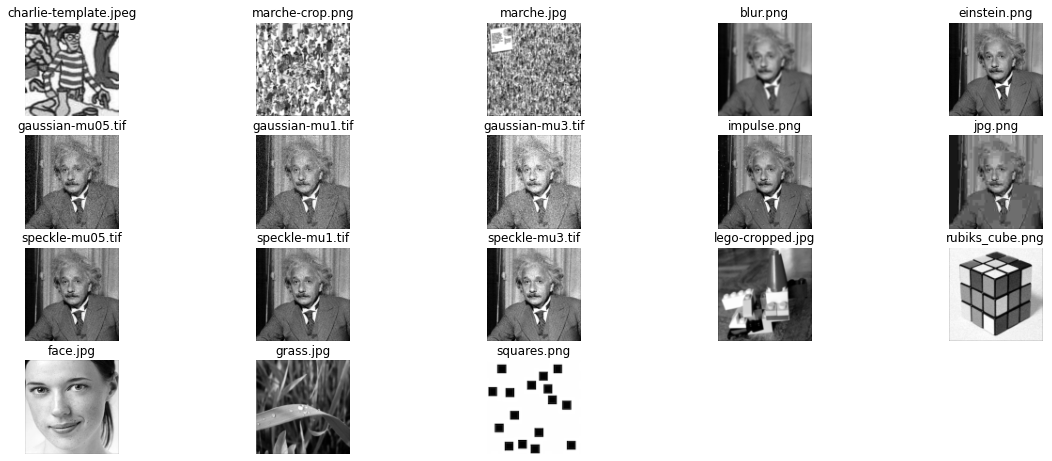

In [7]:

width=20
height=10
plt.rcParams['figure.figsize'] = [width, height]
            
fig=plt.figure()

im_counter = 1
for root, dirnames, filenames in os.walk(IMDIR):
    for filename in filenames:
        f = os.path.join(root, filename)
        
        #filter only image files with the following format
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
            
            # print the paths to current filename if nothing is being found
            # print(filename)
            
            # read the image 
            im = io.imread(f,as_gray=True)
            im = resize(im,(100,100),mode='constant')
            
            # display it
            if im_counter >= 25:
                break;
                
            plt.subplot(5,5,im_counter)
            plt.imshow(im, cmap='gray')
            plt.title(filename)
            plt.axis('off')
            im_counter +=1 

            
            
plt.show()


## 1 Spatial filtering with convolution

### 1.1. Mean Kernel Example
The following ``meanKernel'' function creates a smoothing kernel, which can be used with scipy's ``` ndimage.convolve(im,kernel) ```
convolution function to blur an image.

Run the following cells to display different versions of the kernel and the application of a mean_kernel on an image.



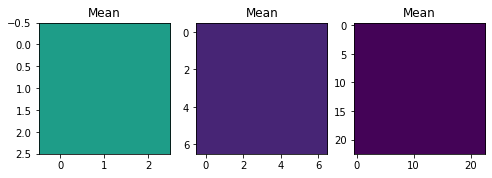

In [8]:
def meanKernel(hs):
    kernel = np.zeros((hs*2+1,hs*2+1))
    kernel += 1/(hs*2+1)**2
    return kernel

width=8
height=3
plt.rcParams['figure.figsize'] = [width, height]

#creating and showing three mean kernels of different sizes
k = 1
for hs in [1,3,11]:
    plt.subplot(1,3,k)
    kernel = meanKernel(hs)
    plt.imshow(kernel, vmin=0, vmax=0.2)
    plt.title('Mean')
    k+=1
plt.show()


Text(0.5, 1.0, 'Mean scipy conv')

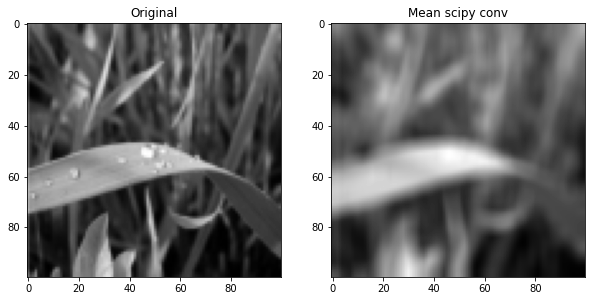

In [9]:
SUBDIR = os.path.join(IMDIR, "smooth")
f = os.path.join(SUBDIR, "grass.jpg")

width=10
height=5

hs = 3
sigma = 2

im = io.imread(f, as_gray=True)
im = im.astype(float)

im = resize(im,(100,100))   

kernel = meanKernel(hs)
#im_filtered=myConvolution(im,kernel)
im_filtered_scipy = ndimage.convolve(im,kernel)

fig=plt.figure(figsize=(width, height))
plt.subplot(1,2,1)        
plt.imshow(im, cmap = 'gray')
plt.title('Original')
        
plt.subplot(1,2,2)
plt.imshow(im_filtered_scipy, cmap = 'gray')
plt.title('Mean scipy conv')


### 1.2. Gaussian Kernel
Following the above example, create, display and apply several (at least 3) Gaussian kernels with varying window size and standard deviation. 

```Hints```:
- use the 'None' or 'Nearest' interpolation options of imshow to display the kernel images

In [10]:
#both versions work, pick the one you are more confortable with
def gaussianKernel(hs,sig): #half window size and Gaussian sigma
    kernel = np.zeros((hs*2+1,hs*2+1))
    ax = np.arange(-hs, hs+1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))
    return kernel / np.sum(kernel)

import math
def gaussianLambdaKernel(size,sigma): #full window size and Gaussian sigma
    kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2)), (size, size))
    return kernel / np.sum(kernel)

Text(0.5, 1.0, 'Gaussian scipy conv with hs= 7')

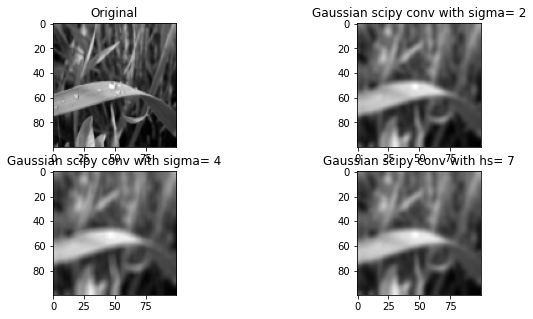

In [11]:
SUBDIR = os.path.join(IMDIR, "smooth")
f = os.path.join(SUBDIR, "grass.jpg")

width=10
height=5

hs = 3
sigma = 2


im = io.imread(f, as_gray=True)
im = im.astype(float)

im = resize(im,(100,100))   

kernel = gaussianKernel(hs,sigma)
#im_filtered=myConvolution(im,kernel)
im_filtered_scipy = ndimage.convolve(im,kernel)

fig=plt.figure(figsize=(width, height))
plt.subplot(2,2,1)        
plt.imshow(im, cmap = 'gray')
plt.title('Original')
        
plt.subplot(2,2,2)
plt.imshow(im_filtered_scipy, cmap = 'gray')
plt.title('Gaussian scipy conv with sigma= '+str(sigma))


sigma2 = 4
kernel2 = gaussianKernel(hs,sigma2)
im_filtered_scipy2 = ndimage.convolve(im,kernel2)

plt.subplot(2,2,3)
plt.imshow(im_filtered_scipy2, cmap = 'gray')
plt.title('Gaussian scipy conv with sigma= '+str(sigma2))

hs2 = 7

kernel3 = gaussianKernel(hs2,sigma)
im_filtered_scipy3 = ndimage.convolve(im,kernel3)

plt.subplot(2,2,4)
plt.imshow(im_filtered_scipy3, cmap = 'gray')
plt.title('Gaussian scipy conv with hs= '+str(hs2))



### 1.3 Filtering with your own Convolution
**a)** Repeat the smoothing above with your own implementation of the ```convolution``` function. The function should receive as input an image and a filter kernel (matrix of weights) and return the filtered image. Compare your results with those from the scikit in-built function.

**b)** Apply a Gaussian filter with fixed parameters to 3 of the images in the ``smooth`` folder and display side by side the results of your convolution vs. those of the in-built function to check your implementation is correct. Clearly state on the title of the image which version of the convolution function is being used.


**c)** **Write down your findings**, notably the reasons for any possible difference with the in-built implementation. 

**d)** Why and how can the convolution can be written as a matrix multiplication? why is it interesting?
```Hint```:  see http://cs231n.github.io/convolutional-networks/

In [2]:
def convolution(im,ker):
    k,k1=np.shape(ker)
    hs = k//2
    ker = ker[::-1,::-1]
    a,b=np.shape(im)
    res = np.zeros((a,b))
    
    canvas = np.zeros((a+2*hs,b+2*hs))
    canvas[hs:a+hs,hs:b+hs] = im
    

    for i in range(hs,a+hs):
        for j in range(hs,b+hs):
            res[i-hs,j-hs] = np.sum(ker*canvas[i-hs:i+hs+1,j-hs:j+hs+1])
    
    return res




0.7451776362803032
0.7451776362803034


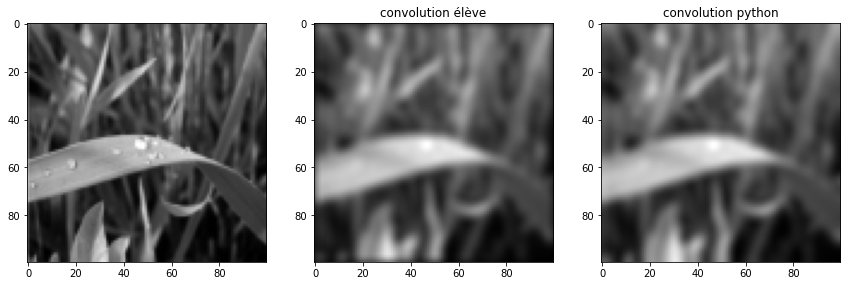

In [13]:
res1 = convolution(im,kernel)
res2 = ndimage.convolve(im,kernel)

plt.figure(1,figsize=(30,40))
plt.subplot(1,6,1)
plt.imshow(im,cmap='gray')
plt.subplot(1,6,2)
plt.imshow(res1,cmap='gray')
plt.title('convolution élève')
plt.subplot(1,6,3)
plt.imshow(res2,cmap='gray')
plt.title('convolution python')

print(res1[50,50])
print(res2[50,50])

## 2. Bilateral Filter

**a)** Implement your own version of the ``bilateral`` filter and compare its results vs. scikit ``denoise_bilateral`` function. 

**b)** Compare the results versus the mean and gaussian filter for one group of images of the ``einstein`` folder. Show the results visually and using the PSNR 



Hint:  Groups:

-the gaussian-m**.tif images

-the speckle-m**.tif images

-the blur, contrast, impulse (salt and pepper noise) and jpeg (jpeg compressed) images



In [15]:
def bilateral(im,hs,sig1,sig2):
    
    kernel1 = np.zeros((hs*2+1,hs*2+1))
    ax = np.arange(-hs, hs+1)
    xx, yy = np.meshgrid(ax, ax)
    kernel1 = np.exp(-(xx**2 + yy**2) / (2. * sig1**2))
    
    a,b = np.shape(im)
    res = np.zeros((a,b))
    kernel2 = np.zeros((hs*2+1,hs*2+1))
    canvas = np.zeros((a+2*hs,b+2*hs))
    canvas[hs:a+hs,hs:b+hs] = im
    
    for i in range(hs,a+hs):
        for j in range(hs,b+hs):
            kernel2 = canvas[i-hs:i+hs+1,j-hs:j+hs+1]
            kernel2 = np.exp((kernel2 - canvas[i,j])**2 / (2. * sig2**2))

            kernel = kernel1 * kernel2
            kernel = kernel[::-1,::-1]
            kernel = kernel / np.sum(kernel)
            
            res[i-hs,j-hs] = np.sum(kernel*canvas[i-hs:i+hs+1,j-hs:j+hs+1])
            
    return res
    



0.6270349736666088 0.6270349737557759 -8.91671181335596e-11


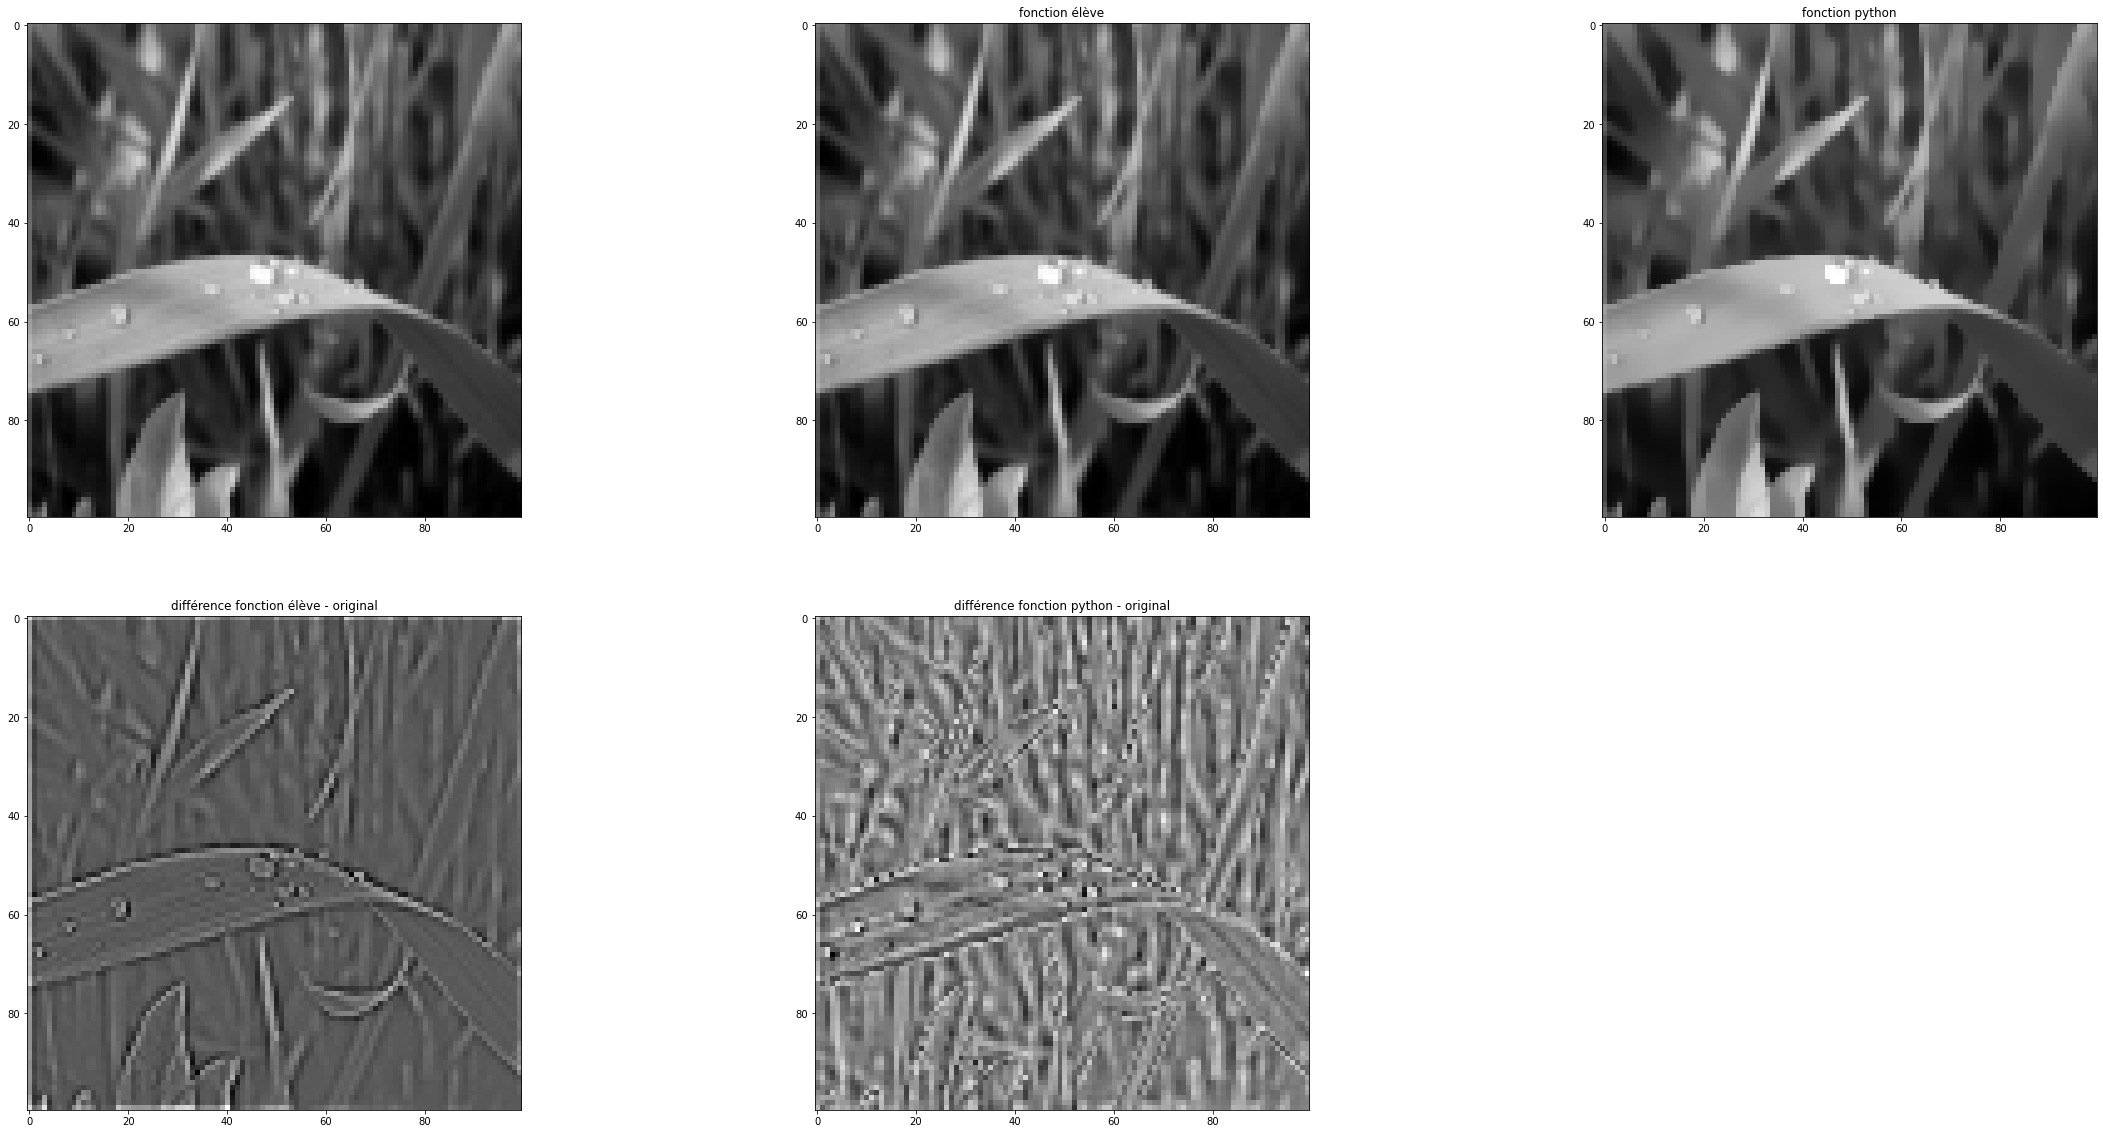

In [17]:
hs = 2
sigma_color=0.15
sigma_spatial=20

SUBDIR = os.path.join(IMDIR, "smooth")
f = os.path.join(SUBDIR, "grass.jpg")
im = io.imread(f, as_gray=True)
im = resize(im,(100,100))   

im_filtered = bilateral(im,hs,sigma_color,sigma_spatial)
im_filtered_scipy = denoise_bilateral(im, win_size=hs*2+1, sigma_color=0.05, sigma_spatial=15)

plt.figure(1,figsize=(40,20))
plt.subplot(2,3,1)
plt.imshow(im,cmap='gray')

plt.subplot(2,3,2)
plt.imshow(im_filtered,cmap='gray')
plt.title('fonction élève')

plt.subplot(2,3,3)
plt.imshow(im_filtered_scipy,cmap='gray')
plt.title('fonction python')

diff = im - im_filtered
plt.subplot(2,3,4)
plt.imshow(diff,cmap='gray')
plt.title('différence fonction élève - original')


diff2 = im - im_filtered_scipy
plt.subplot(2,3,5)
plt.imshow(diff2,cmap='gray')
plt.title('différence fonction python - original')

print(im[50,50],im_filtered[50,50],diff[50,50])

In [109]:
A = np.array(([1,2,3],[4,5,6],[7,8,9]))

## 3. Derivative filters and Harris

3.1 Create a function that generates the kernels required to compute the *image gradient* in the x and in the y direction

3.2. Show the gradient images and the *gradient magnitude* for an image of the 'harris' folder

3.2. Implement the Harris corner detector and apply it to an image of the 'harris' folder or an image of your own with corner content (building, rubik's cube, etc). Follow the algorithm steps from the lecture

**a)** What is the influence of the k parameter?
**b)** What is the Gaussian pre-filtering important?
**c)** Threshold the R map to find the detected corners. 
**b)** Display the score map (R) and the detected corners overlaid over the image 


In [18]:
def gradient(im):
    kernel_x = np.array(([0,0,0],[1,0,-1],[0,0,0]))
    kernel_y = np.array(([0,1,0],[0,0,0],[0,-1,0]))
    
    return convolution(im,kernel_x),convolution(im,kernel_y)

In [19]:
def score(a,b,d,k):
    return a*d-b*d-k*(a+d)**2

In [20]:
def harris(im,hs,sig,k):
    gx,gy = gradient(im)
    gx_2 = gx**2
    gy_2 = gy**2
    gx_gy = gx*gy
    
    kernel = gaussianKernel(hs,sig)
    conv_gx_2 = convolution(gx_2,kernel)
    conv_gy_2 = convolution(gy_2,kernel)
    conv_gx_gy = convolution(gx_gy,kernel)
    
    scores = score(conv_gx_2,conv_gx_gy,conv_gy_2,k)
    return scores


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


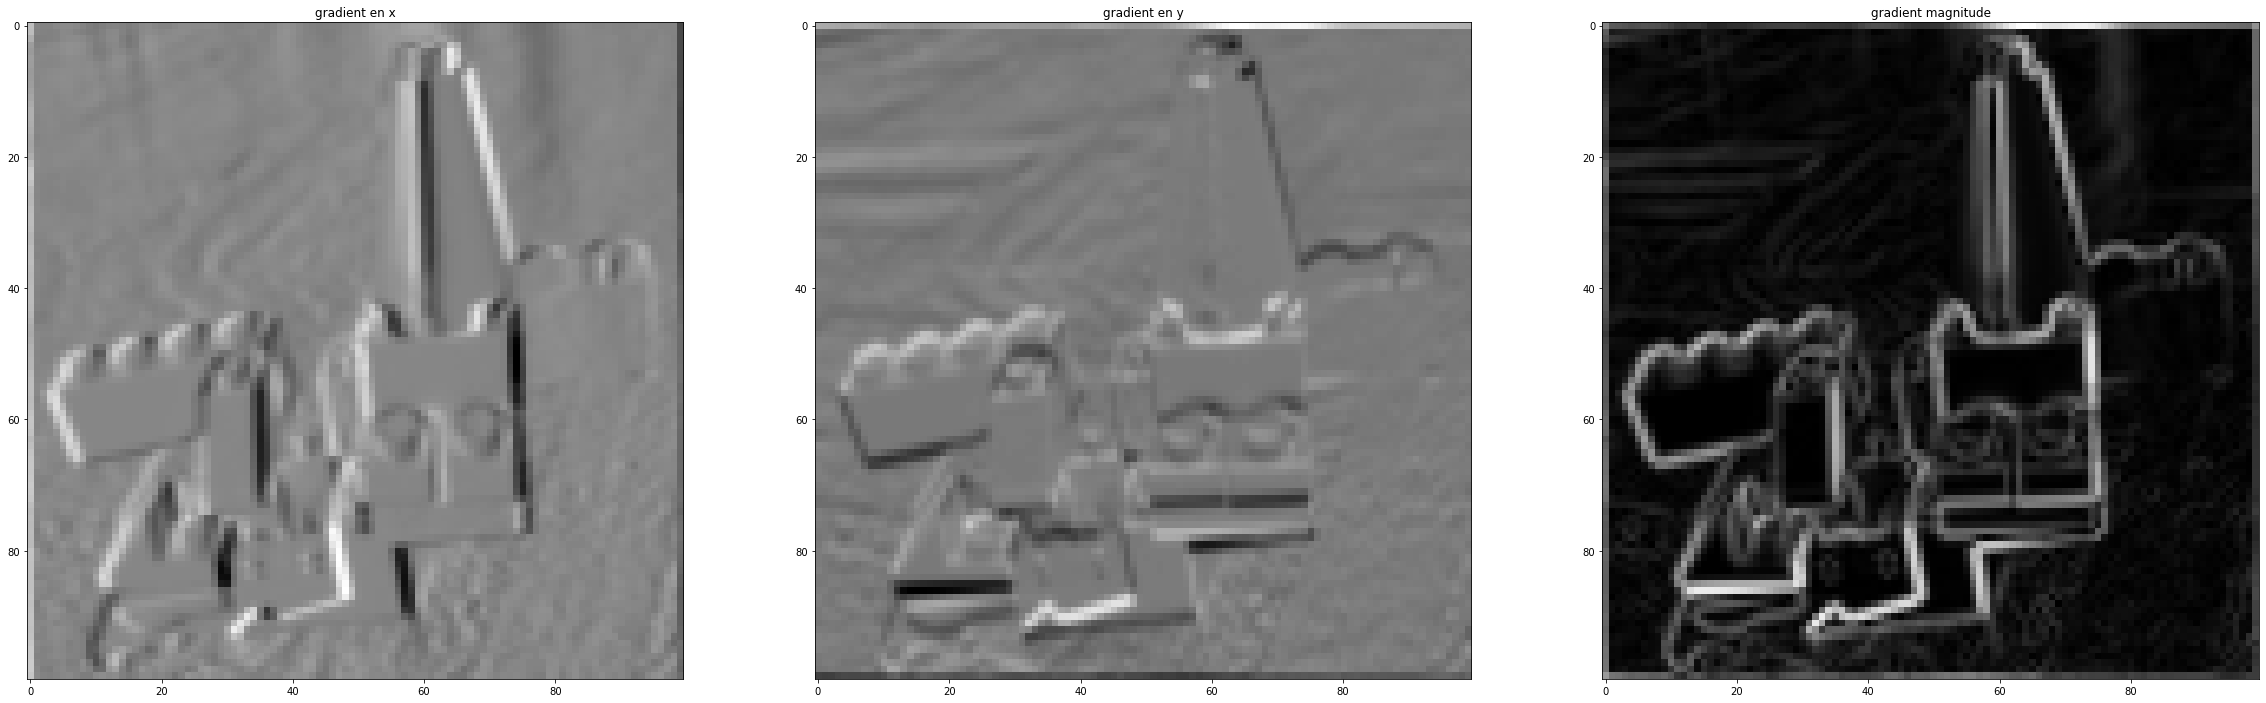

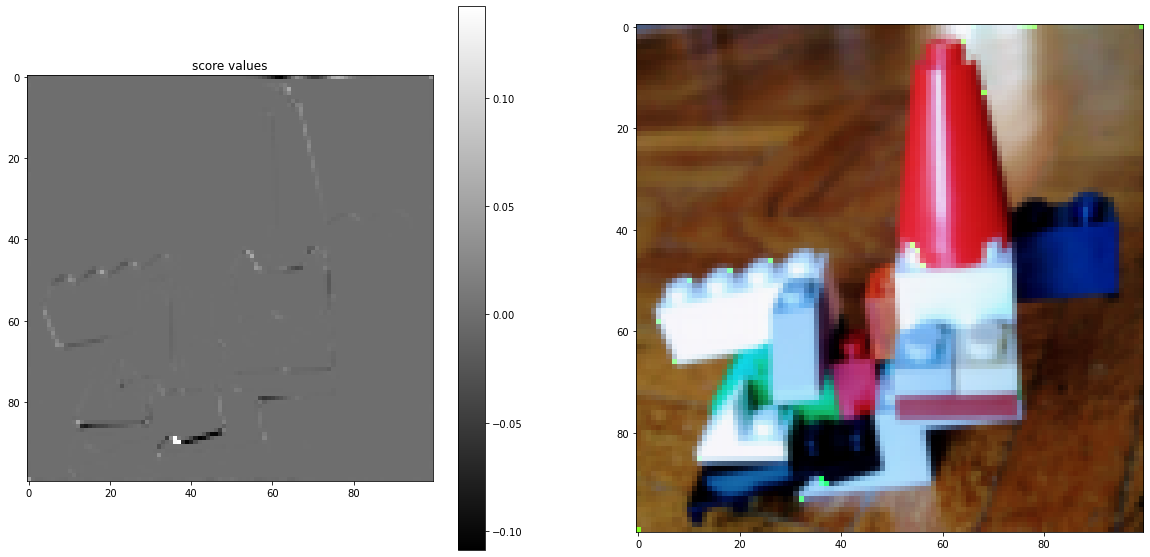

In [21]:
SUBDIR = os.path.join(IMDIR, "harris")
f = os.path.join(SUBDIR, "lego-cropped.jpg")
im = io.imread(f, as_gray=True)
im = resize(im,(100,100))
a,b = np.shape(im)

gx,gy = gradient(im)
mag = (gx**2+gy**2)**0.5

plt.figure(1,figsize=(40,20))
plt.subplot(1,3,1)
plt.imshow(gx,cmap="gray")
plt.title('gradient en x')
plt.subplot(1,3,2)
plt.imshow(gy,cmap="gray")
plt.title('gradient en y')
plt.subplot(1,3,3)
plt.imshow(mag,cmap="gray")
plt.title('gradient magnitude')

scores = harris(im,2,0.1,0.04) #hs,sigma,k
plt.figure(2,figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(scores,cmap="gray")
plt.title('score values')
plt.colorbar()

threshold = 0.2*np.max(scores)
thresh = np.array(scores>threshold,dtype=int)
zeros = np.zeros((a,b))
thresh = np.dstack((zeros,255*thresh,zeros)) #highlighted corners in green

im_color = io.imread(f)
im_color = resize(im_color,(100,100)) + thresh

plt.subplot(1,2,2)
plt.imshow(im_color)

## 4. Find Waldo (Charlie): template matching

Use patch-wise Normalized Cross Correlation (NCC) to automatically find Waldo (Charlie) in an image. To this end, look for the template image (``charlie-template``) inside ``marche-crop`` or the ``marche`` images. As the process can be long start with the cropped version, you might also find it useful to create a separate notebook for this task only. Evaluate the NCC expression from the slides (non-local means) to compare the template with every location in the target image, store the results and retrieve the location with the highest NCC score. Draw this location on the target image.

**Describe the process assumptions and limitations**

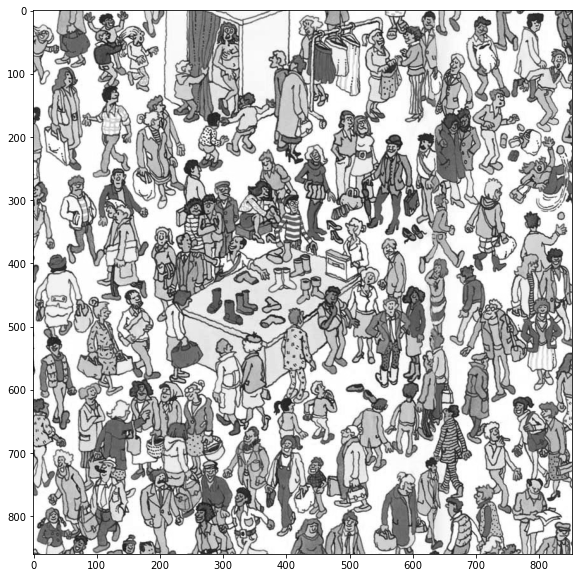

In [286]:
def trouver(im,charlie):
    a,b = np.shape(im)
    m,n = np.shape(charlie)
    charlie = charlie - np.mean(charlie)
    sig_charlie = np.std(charlie.flatten())
    
    NCC = np.zeros((a-m,b-n))
    for i in range(a-m):
        for j in range(b-n):
            window = im[i:i+m,j:j+n]
            mu,sigma = np.mean(window),np.std(window.flatten())
            window = window - mu
            score = np.sum(window*charlie)
            score = score/(sigma*sig_charlie)
            
            NCC[i,j] = score
    
    return NCC
    
    
f = os.path.join(SUBDIR, "marche-crop.png")
im = io.imread(f, as_gray=True)
plt.imshow(im,cmap='gray')

    

In [285]:
SUBDIR = os.path.join(IMDIR, "charlie")
f = os.path.join(SUBDIR, "marche-crop.png")
g = os.path.join(SUBDIR, "charlie-template.jpeg")
im = io.imread(f, as_gray=True)
charlie = io.imread(g, as_gray=True)

NCC = trouver(im,charlie)
print(np.unravel_index(NCC.argmax(), NCC.shape))

(288, 364)
